In [10]:
#data exploration and cleaning

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('diabetes_data_upload.csv')

# Encode categorical variables
symptoms = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 
            'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 
            'delayed healing', 'partial paresis', 'muscle stiffness', 
            'Alopecia', 'Obesity']

encoded_data = data.copy()
for column in symptoms + ['Gender', 'class']:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])


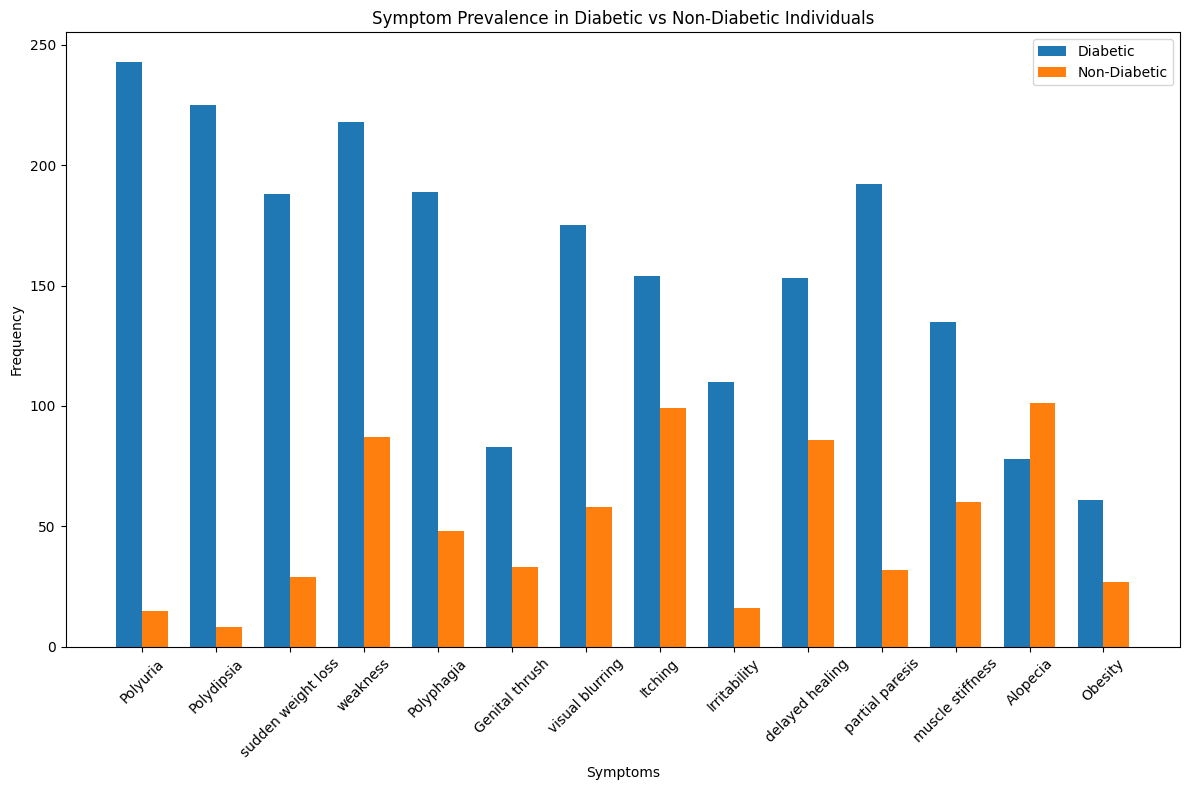

In [11]:
#symptom prevalence analysis

import matplotlib.pyplot as plt

# Separate diabetic and non-diabetic data
diabetes_positive = data[data['class'] == 'Positive']
diabetes_negative = data[data['class'] == 'Negative']

# Count symptom frequencies
positive_counts = diabetes_positive[symptoms].apply(lambda x: (x == 'Yes').sum(), axis=0)
negative_counts = diabetes_negative[symptoms].apply(lambda x: (x == 'Yes').sum(), axis=0)

# Plot symptom prevalence
fig, ax = plt.subplots(figsize=(12, 8))
index = range(len(symptoms))
bar_width = 0.35

ax.bar(index, positive_counts, bar_width, label='Diabetic')
ax.bar([i + bar_width for i in index], negative_counts, bar_width, label='Non-Diabetic')

ax.set_xlabel('Symptoms')
ax.set_ylabel('Frequency')
ax.set_title('Symptom Prevalence in Diabetic vs Non-Diabetic Individuals')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(symptoms, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


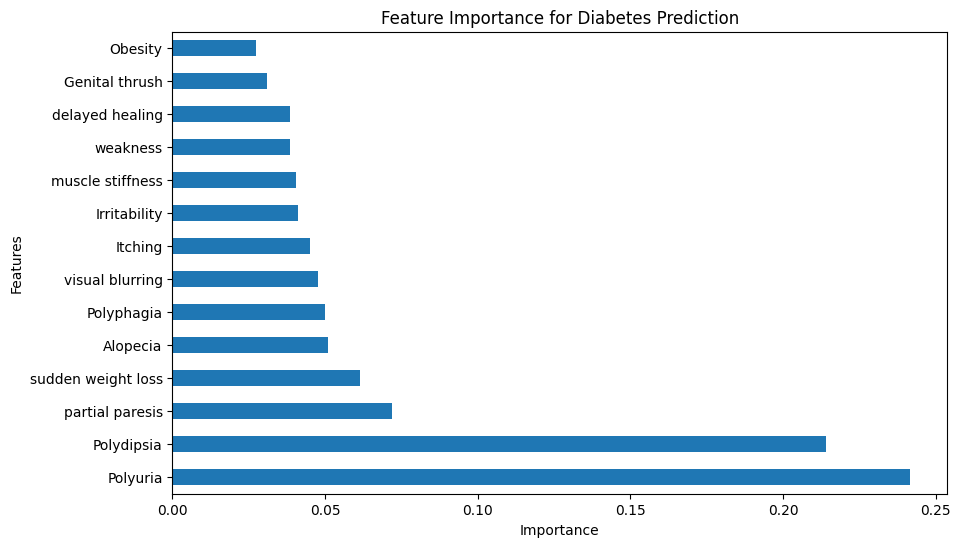

In [12]:
#feature importance ranking

from sklearn.ensemble import RandomForestClassifier

# Split features and target variable
X = encoded_data[symptoms]
y = encoded_data['class']

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Feature importance ranking
feature_importance = pd.DataFrame({'Feature': symptoms, 
                                    'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
feature_importance.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(10, 6))
plt.title('Feature Importance for Diabetes Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [14]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

app = Dash(__name__)

# Dashboard layout
app.layout = html.Div([
    html.H1('Diabetes Data Dashboard', style={'textAlign': 'center'}),
    
    # Dropdown for gender filter
    html.Div([
        html.Label('Filter by Gender:'),
        dcc.Dropdown(
            id='gender-filter',
            options=[{'label': gender, 'value': gender} for gender in data['Gender'].unique()],
            value='Male'
        )
    ]),
    
    # Symptom prevalence graph
    dcc.Graph(id='symptom-prevalence-graph'),

    # Feature importance graph
    dcc.Graph(
        id='feature-importance-graph',
        figure=px.bar(feature_importance, x='Feature', y='Importance',
                      title='Feature Importance for Diabetes Prediction')
    )
])

# Callback to update symptom prevalence graph based on gender filter
@app.callback(
    Output('symptom-prevalence-graph', 'figure'),
    [Input('gender-filter', 'value')]
)
def update_symptom_prevalence(selected_gender):
    filtered_data = data[data['Gender'] == selected_gender]
    positive_counts = filtered_data[filtered_data['class'] == 'Positive'][symptoms].apply(lambda x: (x == 'Yes').sum(), axis=0)
    negative_counts = filtered_data[filtered_data['class'] == 'Negative'][symptoms].apply(lambda x: (x == 'Yes').sum(), axis=0)

    fig = go.Figure()
    fig.add_trace(go.Bar(x=symptoms, y=positive_counts, name='Diabetic'))
    fig.add_trace(go.Bar(x=symptoms, y=negative_counts, name='Non-Diabetic'))

    fig.update_layout(
        title=f'Symptom Prevalence ({selected_gender})',
        xaxis_title='Symptoms',
        yaxis_title='Frequency',
        barmode='group'
    )
    return fig

if __name__ == '__main__':
    app.run(debug=False)
